In [1]:
import sys
sys.path.append(os.path.abspath('/local/PtychoPINN'))

In [2]:
from ptycho_torch.api.base_api import ConfigManager, PtychoDataLoader, PtychoModel, Trainer, InferenceEngine

# Part 1. Config Manager

Let's set up a config manager using both a json and then loading directly from an mlflow run.

## Method 1: JSON

In [3]:
#Let's set up a config manager using two methods
json_path = '../configs/publication_configs/4_q_multi_gpu_velociprobe.json'
config_manager_json, _ = ConfigManager._from_json(json_path)


Successfully loaded configuration from: ../configs/publication_configs/4_q_multi_gpu_velociprobe.json
Configuration validation completed.


## Method 2: MLFlow run

In [4]:
mlflow_tracking_uri = "/local/CDI-PINN/mlruns"
run_id = "f637381fd7fe49158bb0ed2e7a28ca45"

config_manager_mlflow = ConfigManager._from_mlflow(run_id,
                                                   mlflow_tracking_uri)

Successfully loaded configuration from run f637381fd7fe49158bb0ed2e7a28ca45 from tracking uri /local/CDI-PINN/mlruns


## Using the update function with a dictionary

In [10]:
print(config_manager_mlflow.data_config)

DataConfig(nphotons=100000.0, N=64, C=4, K=6, K_quadrant=60, n_subsample=1, grid_size=[2, 2], neighbor_function='4_quadrant', min_neighbor_distance=0.5, max_neighbor_distance=8, scan_pattern='Rectangular', normalize='Batch', probe_scale=1.0, probe_normalize=True, data_scaling='Parseval', phase_subtraction=True, x_bounds=[0.05, 0.95], y_bounds=[0.05, 0.95])


Here, we'll modify the nphotons number just as a demonstration of how to use the update function

In [12]:
data_config_update = {'nphotons': 5e4}

config_manager_mlflow.update(data_config = data_config_update)
print(config_manager_mlflow.data_config)

#We can see we've successfully updated the data config.

DataConfig(nphotons=50000.0, N=64, C=4, K=6, K_quadrant=60, n_subsample=1, grid_size=[2, 2], neighbor_function='4_quadrant', min_neighbor_distance=0.5, max_neighbor_distance=8, scan_pattern='Rectangular', normalize='Batch', probe_scale=1.0, probe_normalize=True, data_scaling='Parseval', phase_subtraction=True, x_bounds=[0.05, 0.95], y_bounds=[0.05, 0.95])


# Part 2. Dataloader

In [58]:
import importlib
import ptycho_torch.api.base_api
import ptycho_torch.dataloader

importlib.reload(ptycho_torch.api.base_api)
importlib.reload(ptycho_torch.dataloader)

from ptycho_torch.api.base_api import ConfigManager, PtychoDataLoader, PtychoModel, Trainer, InferenceEngine
import ptycho_torch.dataloader

In [59]:
from ptycho_torch.api.base_api import DataloaderFormats

The dataloader has two main current formats: ```Lightning``` and  ```Tensordict```. 

```Lightning``` is more useful for training since the dataloader will be generated during training and is compaitable with distributed data parallel (DDP) for multi-gpu training with the tensordict dataloader.

```Tensordict``` spawns the base Dataset and Dataloader instances which can be used to inspect the data or use for inference.

First, let's provide an arbitrary path to some training data we want to use. We make zero distinction between synthetic and real data, only parsing whatever .npz files exist within the directory. Note that the dataset creation automatically handles multiple experiments. To see how additional details/how the dataset class handles distinguishing amongst different npz files/experiments, see ```ptycho_torch.dataloader.py``` for details

In [60]:
ptycho_data_dir = "/local/CDI-PINN/data/pinn_velo_ncm"
os.path.exists(ptycho_data_dir)

True

## Lightning Dataloader

In [61]:
lightning_dataloader = PtychoDataLoader(data_dir = ptycho_data_dir,
                                        config_manager = config_manager_mlflow,
                                        data_format = DataloaderFormats('lightning_module'))

Set up lightning datamodule


## Tensordict Dataloader

Note that instantiating the ```PtychoDataLoader``` with the tensordict format will create both a dataset object and dataloader object, which can both be accessed as attributes after class instantiation. We'll reference the dataset object so we can take a look inside to check it works.

In [ ]:
tensordict_dataloader = PtychoDataLoader(data_dir = ptycho_data_dir,
                                        config_manager = config_manager_mlflow,
                                        data_format = DataloaderFormats('tensordict'))



Calculating dataset length with coordinate bounds...
For file /local/CDI-PINN/data/pinn_velo_ncm/nxs_data_ncm_1_64_train.npz, maximum x_range is (33.11264419555664, 240.88735961914062), yrange is (33.431095123291016, 232.56890869140625)
Creating memory mapped tensor dictionary...
Memory map length: 1902
Memory map creation time: 0.0018334388732910156
Populating memory map for dataset 0
Start - end = 1902
Building KDTree for 2466 points...
Processing 1902 potential central points...
Finished quadrant neighbor processing. Found 1902 valid C=4 groups.
Non-diffraction memory map write time: 0.23435759544372559
Getting normalization coefficients...
Batch rms factor is tensor([[[[0.0012]]]])
Diffraction memory map write time: 0.07936739921569824
[PtychoDataset Rank 0] Initialization successful. Dataset length: 1902.
Setup ptycho dataset
Setup ptycho dataloader


In [42]:
tensordict_dataloader.dataset[1:4]

(TensorDict(
     fields={
         coords_center: MemoryMappedTensor(shape=torch.Size([3, 1, 1, 2]), device=cpu, dtype=torch.float32, is_shared=True),
         coords_global: MemoryMappedTensor(shape=torch.Size([3, 4, 1, 2]), device=cpu, dtype=torch.float32, is_shared=True),
         coords_relative: MemoryMappedTensor(shape=torch.Size([3, 4, 1, 2]), device=cpu, dtype=torch.float32, is_shared=True),
         coords_start_center: MemoryMappedTensor(shape=torch.Size([3, 1, 1, 2]), device=cpu, dtype=torch.float32, is_shared=True),
         coords_start_relative: MemoryMappedTensor(shape=torch.Size([3, 4, 1, 2]), device=cpu, dtype=torch.float32, is_shared=True),
         experiment_id: MemoryMappedTensor(shape=torch.Size([3]), device=cpu, dtype=torch.int32, is_shared=True),
         images: MemoryMappedTensor(shape=torch.Size([3, 4, 64, 64]), device=cpu, dtype=torch.float32, is_shared=True),
         label_amp: MemoryMappedTensor(shape=torch.Size([3, 4, 64, 64]), device=cpu, dtype=torch.f

# Part 3. Model

In [36]:
import importlib
from ptycho_torch.api.base_api import Orchestration
from ptycho_torch.model import PtychoPINN_Lightning

In [52]:
import ptycho_torch.api.base_api
importlib.reload(ptycho_torch.api.base_api)
from ptycho_torch.api.base_api import PtychoModel, ConfigManager

We can either instantiate a baseline model based off a config manager, or we can "load" from mlflow

## Instantiating untrained model

In [25]:
new_ptycho_model = PtychoModel._new_model(model = PtychoPINN_Lightning,
                                          config_manager = config_manager_mlflow)

Decoder Block 1: No attention module added.
Decoder Block 2: No attention module added.
Decoder Block 1: No attention module added.
Decoder Block 2: No attention module added.


## Loading model from trained mlflow run

In [53]:
loaded_ptycho_model = PtychoModel._load(strategy = 'mlflow',
                                        run_id = run_id,
                                        mlflow_tracking_uri = mlflow_tracking_uri)

In [54]:
print(f"Model uri: {loaded_ptycho_model.mlflow_tracking_uri}")
print(f"Model id: {loaded_ptycho_model.run_id}")
print(loaded_ptycho_model.model)

Model uri: /local/CDI-PINN/mlruns
Model id: f637381fd7fe49158bb0ed2e7a28ca45
PtychoPINN_Lightning(
  (model): PtychoPINN(
    (autoencoder): Autoencoder(
      (encoder): Encoder(
        (blocks): ModuleList(
          (0): ConvPoolBlock(
            (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
            (attention): CBAM(
              (ChannelGate): ChannelGate(
                (mlp): Sequential(
                  (0): Flatten(start_dim=1, end_dim=-1)
                  (1): Linear(in_features=64, out_features=4, bias=True)
                  (2): ReLU()
                  (3): Linear(in_features=4, out_features=64, bias=True)
                )
              )
              (SpatialGate): SpatialGate(
                (compress): Conv2d(2, 1, kernel_size=(7, 7), strid

Now we test out the saving method using an arbitrary save location.

In [55]:
new_model_uri = loaded_ptycho_model.save("/local/PtychoPINN",
                         strategy = 'mlflow')

print(new_model_uri)

✓ New tracking URI: file:///local/PtychoPINN/mlruns
file:///local/PtychoPINN/mlruns


Now we can check if our newly saved model works

In [57]:
new_loaded_model = PtychoModel._load(strategy = 'mlflow',
                                     run_id = run_id,
                                     mlflow_tracking_uri = new_model_uri.replace('file://',''))

print(f"Model uri: {new_loaded_model.mlflow_tracking_uri}")
print(f"Model id: {new_loaded_model.run_id}")
print(new_loaded_model.model)

Model uri: /local/PtychoPINN/mlruns
Model id: f637381fd7fe49158bb0ed2e7a28ca45
PtychoPINN_Lightning(
  (model): PtychoPINN(
    (autoencoder): Autoencoder(
      (encoder): Encoder(
        (blocks): ModuleList(
          (0): ConvPoolBlock(
            (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
            (attention): CBAM(
              (ChannelGate): ChannelGate(
                (mlp): Sequential(
                  (0): Flatten(start_dim=1, end_dim=-1)
                  (1): Linear(in_features=64, out_features=4, bias=True)
                  (2): ReLU()
                  (3): Linear(in_features=4, out_features=64, bias=True)
                )
              )
              (SpatialGate): SpatialGate(
                (compress): Conv2d(2, 1, kernel_size=(7, 7), str

# Part 4. Trainer

Training doesn't work within the notebook due to DDP spawning multiple instances/not being compatible with dynamic environments such as notebook, so look at ```example_train.py``` in the same api subdirectory for an example

# Part 5. Inference

We'll repeat the same steps as above in one set of lines so you can see exactly how inference can be called from a cold start. We almost always want to load a model since mlflow automatically saves models during training, and loading has minimal latency in the long run.

Note that the ```memory_map_dir``` argument in the dataloader controls where the memory map is being created/referenced. This can change depending on needs. It currently accepts relative directory paths.

In [19]:
import importlib
import ptycho_torch.api.base_api
importlib.reload(ptycho_torch.api.base_api)
from ptycho_torch.api.base_api import InferenceEngine, ConfigManager
import matplotlib.pyplot as plt
import numpy as np

In [15]:
#1. Config Manager

mlflow_tracking_uri = "/local/CDI-PINN/mlruns"
run_id = "06822d7239504a93ae0f7a6c4577cdc8" #Trained model

config_manager_mlflow = ConfigManager._from_mlflow(run_id,
                                                   mlflow_tracking_uri)


#2. Dataloader
ptycho_data_dir = "/local/CDI-PINN/data/pinn_velo_ncm"
tensordict_dataloader = PtychoDataLoader(data_dir = ptycho_data_dir,
                                        config_manager = config_manager_mlflow,
                                        data_format = 'tensordict',
                                        memory_map_dir = 'data/memmap')

#3. Model
trained_ptycho_model = PtychoModel._load(config_manager = config_manager_mlflow,
                                         strategy = 'mlflow',
                                         run_id = run_id,
                                         mlflow_tracking_uri = mlflow_tracking_uri)


#4. Inference
ptycho_inference = InferenceEngine(ptycho_model = trained_ptycho_model,
                                   config_manager = config_manager_mlflow)   

Successfully loaded configuration from run 06822d7239504a93ae0f7a6c4577cdc8 from tracking uri /local/CDI-PINN/mlruns
Calculating dataset length with coordinate bounds...
For file /local/CDI-PINN/data/pinn_velo_ncm/nxs_data_ncm_1_64_train.npz, maximum x_range is (33.11264419555664, 240.88735961914062), yrange is (33.431095123291016, 232.56890869140625)
Creating memory mapped tensor dictionary...
Memory map length: 1902
Memory map creation time: 0.0008263587951660156
Populating memory map for dataset 0
Start - end = 1902
Building KDTree for 2466 points...
Processing 1902 potential central points...
Finished quadrant neighbor processing. Found 1902 valid C=4 groups.
Non-diffraction memory map write time: 0.12977290153503418
Getting normalization coefficients...
Batch rms factor is tensor([[[[0.0012]]]])
Diffraction memory map write time: 0.06346464157104492
[PtychoDataset Rank 0] Initialization successful. Dataset length: 1902.
Setup ptycho dataset
Setup ptycho dataloader


Now with everything available (model, dataloader, inference engine), we can call the inference engine (instantiated with a specific model and configuration) to infer/stitch a given dataloader which we have just prepped.

In [11]:
import ptycho_torch.reassembly
importlib.reload(ptycho_torch.reassembly)
import ptycho_torch.reassembly

In [16]:
print(f"Beginning inference...")

res_cpu = ptycho_inference.predict_and_stitch(tensordict_dataloader)

Beginning inference...


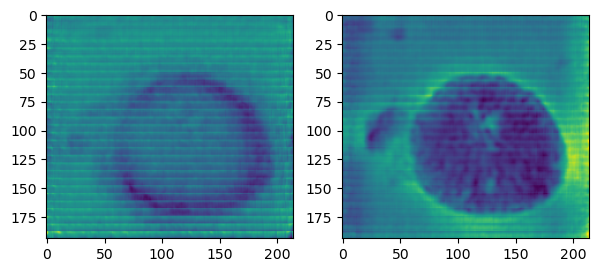

In [21]:
im_to_plot = res_cpu[20:-20,10:-10] #Due to edge effects

fig, axs = plt.subplots(1,2,figsize=(7,5))
axs[0].imshow(np.abs(im_to_plot))
axs[1].imshow(np.angle(im_to_plot))

# Datagen